# **Microgel Sample**
Specifications of the sample and measurement can be found in the README file.

This notebook demonstrates how the pyDWS package can be used to blend and merge Echo and two-cell data. It further illustrates how to fit the merged ICF, calculate the mean squared displacement (MSD), apply the microrheology routine to the MSD, and perform corrections for bead and fluid inertia.

In [1]:
import os
import numpy as np
from pyDWS import data_preprocessing, loading_data, generate_echoPeaks, echo_peakFit, tc_echo_merge, icf_fit, msd, microrheology, inertia_correction


# Loading Data

In [2]:
echoPath = r".\data\microgel\echo"
twoCellPath = r".\data\microgel\twocell"
mergePath = r".\data\microgel"
mergePlots = r".\data\microgel\plots"
os.makedirs(mergePlots, exist_ok=True)

# loading Files & save raw files
echotrace, echo_data = loading_data(os.path.join(echoPath, 'Raw Data.csv'), save=echoPath)
tctrace, tc_ICF = loading_data(os.path.join(twoCellPath, 'Raw Data.csv'), save=twoCellPath)


| Created files                 | Columns               |
|------------------------------|-----------------------|
| `icf_raw.txt` (for two-cell) | Lag time, ICF         |
| `icf_raw.txt` (raw echo)     | Lag time, echo peaks  |

In [3]:
print('echo icf: ', echo_data)
print('tc icf: ', tc_ICF)

echo icf:               0         1
0     0.000013  0.650563
1     0.000026  0.515873
2     0.000038  0.370267
3     0.000051  0.256168
4     0.000064  0.182300
..         ...       ...
846  13.040179  0.379193
847  13.040192  0.275721
848  13.040205  0.191630
849  13.040218  0.134706
850  13.040230  0.106629

[851 rows x 2 columns]
tc icf:                  0         1
0    1.250000e-08  0.960207
1    2.500000e-08  0.935508
2    3.750000e-08  0.941895
3    5.000000e-08  0.948527
4    6.250000e-08  0.917378
..            ...       ...
254  1.879048e+02  0.082671
255  2.013266e+02 -0.039539
256  2.147484e+02 -0.058700
257  2.415919e+02 -0.049504
258  2.684355e+02  0.140660

[259 rows x 2 columns]


# Calculation of echo ICF

First, the Echo ICF must be calculated from the raw Echo data. Each Echo peak is fitted with either a Lorentzian or Gaussian function, and the area under the fit provides the corresponding ICF value for the given lag time, which is defined by the center of the peak. In contrast, the two-cell data already represent the ICF directly.

Peak distribution:  [  1   2   3   4   5   6   7   8  10  12  14  16  18  20  22  25  28  31
  34  37  40  43  47  51  55  59  63  67  71  76  81  86  91  96 101 106
 112 118 124 130 136 142 148 155 162 169 176 183 190 197 205 213 221 229
 237 245 253 262 271 280 289 298 307 316]
t:  0.04000048000576007
Lorentzian
t:  0.08000096001152014
Lorentzian
t:  0.1200014400172802
Lorentzian
t:  0.16000192002304028
Lorentzian
t:  0.20000240002880035
Lorentzian
t:  0.2400028800345604
Lorentzian
t:  0.2800033600403205
Lorentzian
t:  0.32000384004608057
Lorentzian
t:  0.4000048000576007
Lorentzian
t:  0.4800057600691208
Lorentzian
t:  0.560006720080641
Lorentzian
t:  0.6400076800921611
Lorentzian
t:  0.7200086401036813
Lorentzian
t:  0.8000096001152014
Lorentzian
t:  0.8800105601267215
Lorentzian
t:  1.0000120001440016
Lorentzian
t:  1.120013440161282
Lorentzian
t:  1.2400148801785622
Lorentzian
t:  1.3600163201958424
Lorentzian
t:  1.4800177602131226
Lorentzian
t:  1.6000192002304028
Lorentzian
t:

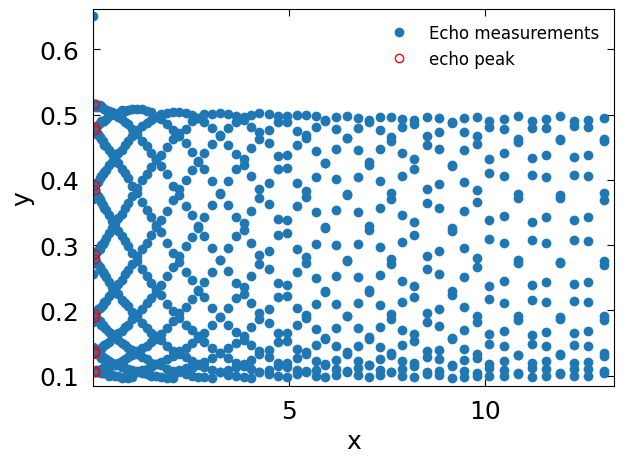

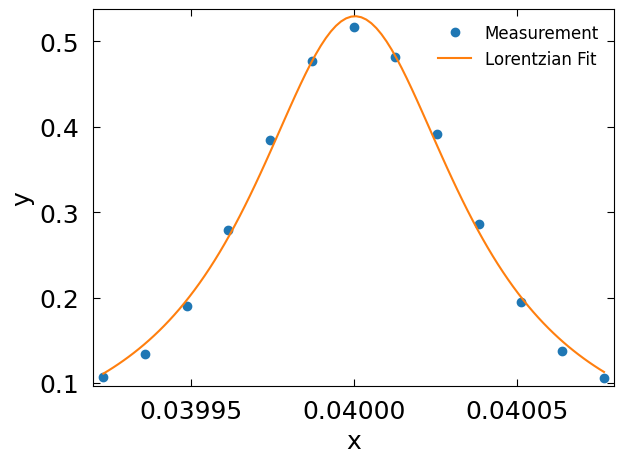

In [4]:
peakIndex = generate_echoPeaks() # generates the indices of the echo peaks
frequency = 24.9997     # effective Frequency of the echo peaks
plotPeakIndex = 1       # Index of the peak to be plotted

# Fitting echo peaks either with a Lorenzian or a Gaussian -> in this case Lorentzian is the right fitting method
echo_ICF = echo_peakFit(echo_data, peakIndex, frequency, fitModel='Lorentzian', plot_ind=plotPeakIndex, savePlot=echoPath, saveEcho=echoPath)

#echo_ICF = echo_peakFit(echo_data, peakIndex, frequency, fitModel='Gaussian', plot_ind=plotPeakIndex, savePlot=None, saveEcho=None)

| Created file      | Columns                 |
|------------------|------------------------|
| `icf_echo.txt`    | t, a, μ, σ, area, r²   |

# Merging and Blending Two-Cell and Echo Data

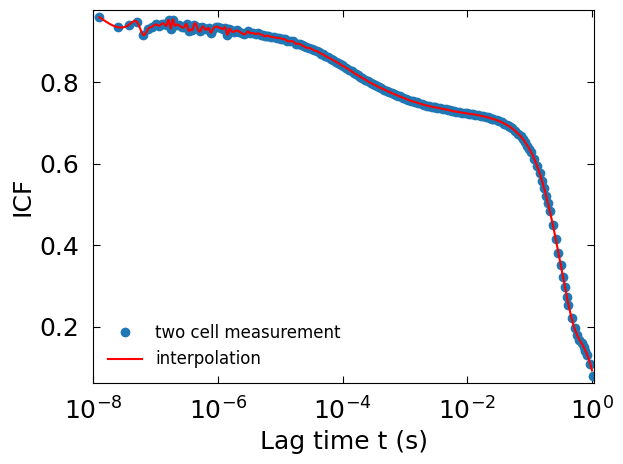

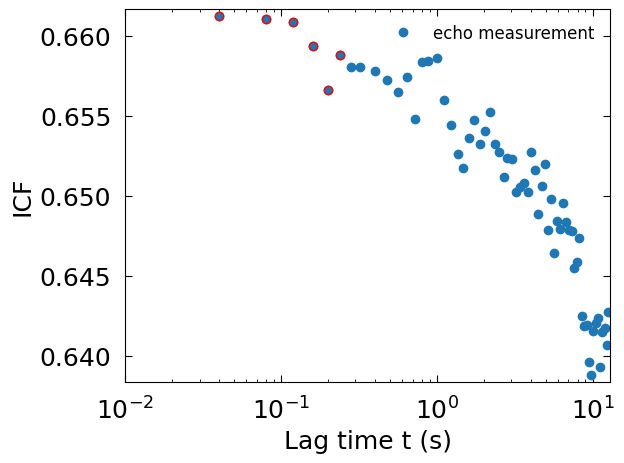

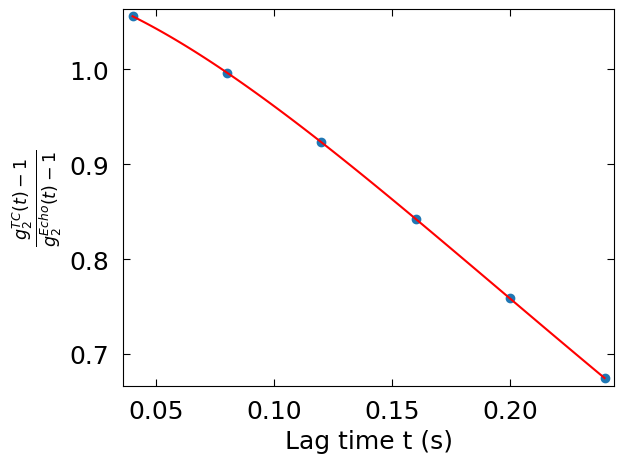

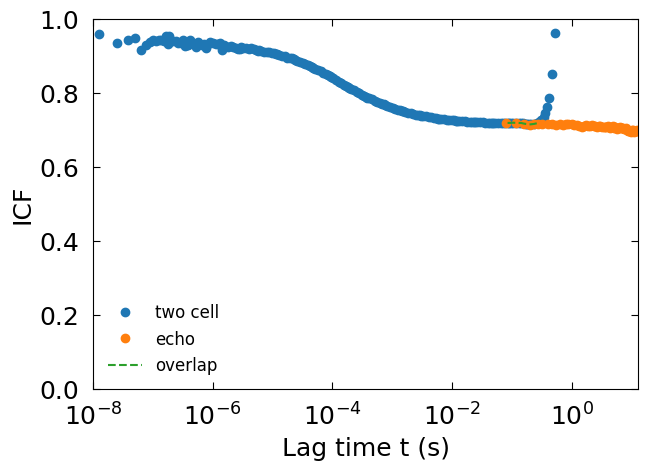

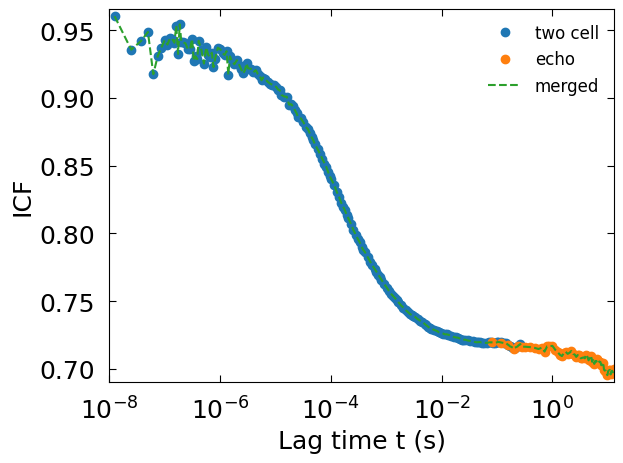

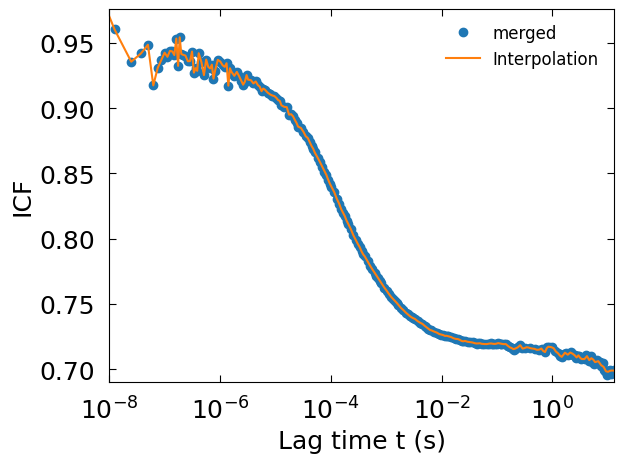

In [5]:
# filtering two-cell data
tc_ICF = tc_ICF[tc_ICF.iloc[:,0] < 1.1].copy()

overlap_Npoints = 6       # number of echo & two-cell points for the ratio calculation
overlap_range = 0.004     # overlap threshold of the two-cell & echo (which two-cell data to take into account in the merging process)
fit_P = True             # whether p is fitted or not (A exp(-(t/tauTC)^p)

# merging two-cell and echo ICF data
ratioTC_E, a_tauTC_p, tc_icf_corrected, echo_icf_corrected, tc_echo_mergeData, tc_echo_mergeInt = tc_echo_merge(tc_ICF, echo_ICF, overlap_Npoints, overlap_range, fit_P, mergePlots, mergePath)


| Created files                          | Columns                                                        |
|--------------------------------------|---------------------------------------------------------------|
| `a_tauTC_p.txt`                       | A, $\tau_{TC}$, p (if p is fitted)  Fit: $A e^{-(t/\tau_{TC})^p}$|
| `ratioTC_echo.txt`                     | t, ratio ($\frac{g_2^{TC}(t) - 1}{g_2^{echo}(t) - 1}$)                                                     |
| `echo_corrected.txt`                   | t, icf                                                        |
| `tc_corrected.txt`                     | t, icf                                                        |
| `tc_echo_merged.txt`                   | t, icf                                                        |
| `tc_echo_merged_Interpolation.txt`     | t, icf (icf is interpolated, having same time spacing as two-cell measurement) |


# Fitting Merged ICF

alpha: [1.00000000e-07 4.48168907e-07 2.00855369e-06 9.00171313e-06
 4.03428793e-05 1.80804241e-04 8.10308393e-04 3.63155027e-03
 1.62754791e-02 7.29416370e-02 3.26901737e-01 1.46507194e+00
 6.56599691e+00 2.94267566e+01            inf]


C:\Users\HelferMa\AppData\Local\miniconda3\envs\test\Lib\site-packages\pyDWS\plots.py:66: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(data_xlim[0] - padding_x, data_xlim[1] + padding_x)
C:\Users\HelferMa\AppData\Local\miniconda3\envs\test\Lib\site-packages\pyDWS\plots.py:78: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(data_ylim[0] - padding_y, data_ylim[1] + padding_y)


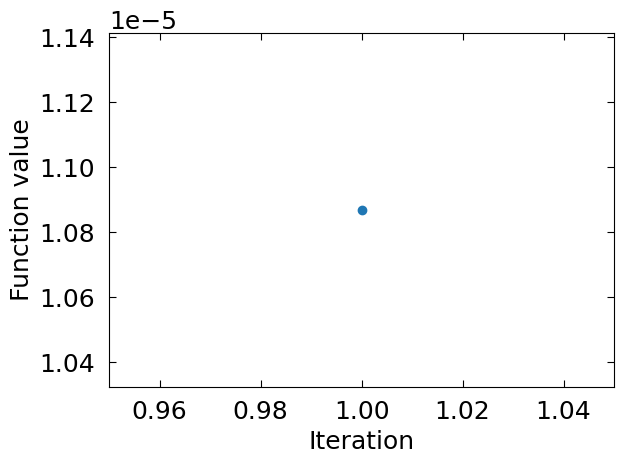

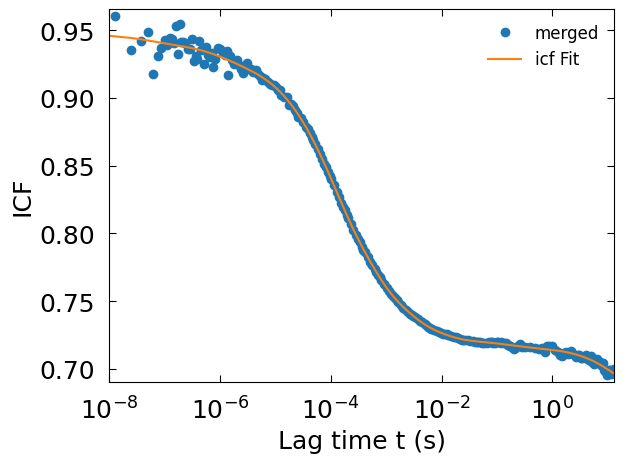

In [6]:
# The fit is performed on the interpolated merged two-cell - echo data
# name of the file, where the fitted parameters are saved
nameFitParam = 'microgelT28-1_5'
# set alpha range for the fitting
# spacing can be set smaller, but the fitting time increases significantly
aRange = np.arange(0, 22.5, 1.5)
#aRange = np.arange(0, 25, 0.5)
# plateauVal is set to True because, for this data, we expect the intensity correlation function (ICF) to reach a plateau.

# if you give the path of the merged data
# fittedICF = icf_fit(os.path.join(mergePath, 'tc_echo_merged_Interpolation.txt'), nameFitParam, alphaRange=aRange, plateauVal=False, max_iterations=400, iteration_step = 10000, PathPguess=mergePath , icfFitPath=mergePath, savePlots=mergePlots)
# if you directly hand over the dataframe
fittedICF = icf_fit(tc_echo_mergeData, nameFitParam, alphaRange=aRange, plateauVal=True, max_iterations=400, iteration_step = 10000, PathPguess=mergePath , icfFitPath=mergePath, savePlots=mergePlots)

# fittedICF is a dictionary saved in a Jason file

| Created files                        | Columns                                                         |
|------------------------------------|----------------------------------------------------------------|
| `icf_fit.txt`                       | t, icf, intercept, alpha, P, fun, NIter, MinIter               |
| `ICFfitguess_micelleT20-1_5.npy`   | Fitted Pi values                                               |


# Calculation of the mean square displacement (MSD)

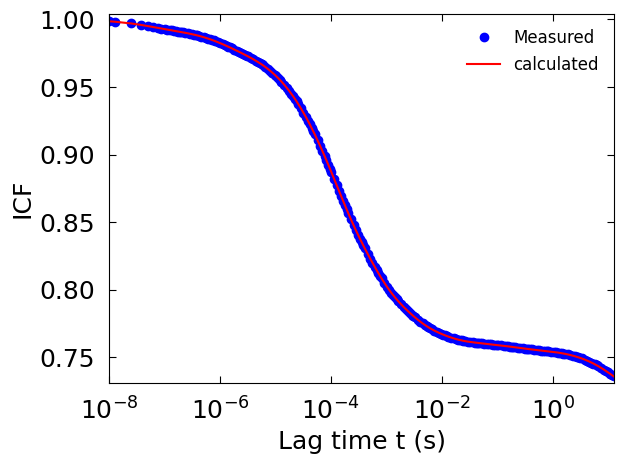

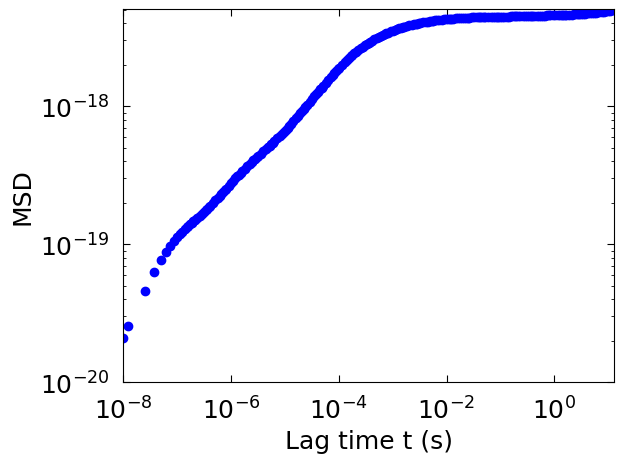

In [7]:
# converting the list of the dictionary in numpy arrays
fittedICF_np = {k: np.array(v) for k, v in fittedICF.items()}
# print(fittedICF_np)

# normalizing the data correctly 
gd = fittedICF_np['icf'] / fittedICF_np['intercept']
td = fittedICF_np['t']


# Parameters of your setup
lstar = 157e-6            # l* transport mean free path
lambda_laser = 633e-9     # laser wavelength λ
L = 5e-3                  # slab thickness
n = 1.333                 # refractive index
radi = 293e-9             # radius of the particles in the sample
range_icf = [1e-8, 10]    # time range of the ICF


# msd calculation
msdD, g_cal, history = msd(td, gd, lstar, lambda_laser, L, n, radi, range_icf, msdPath=mergePath, savePlots=mergePlots)


| Created file | Columns   |
|--------------|-----------|
| `msd.txt`    | t, msd    |


# Microrheology routine

Smoothing using Butterworth Lowpass Filter...


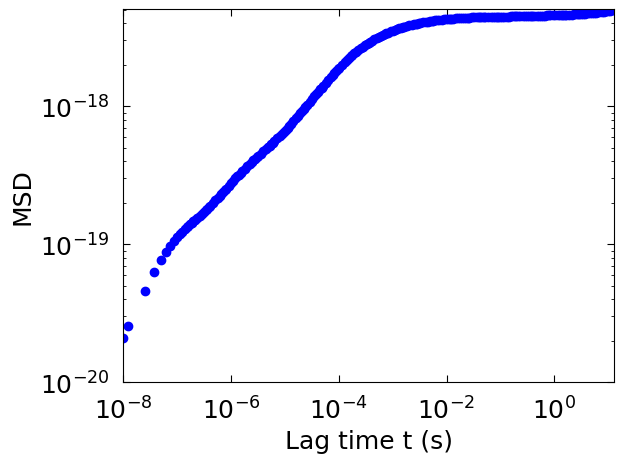

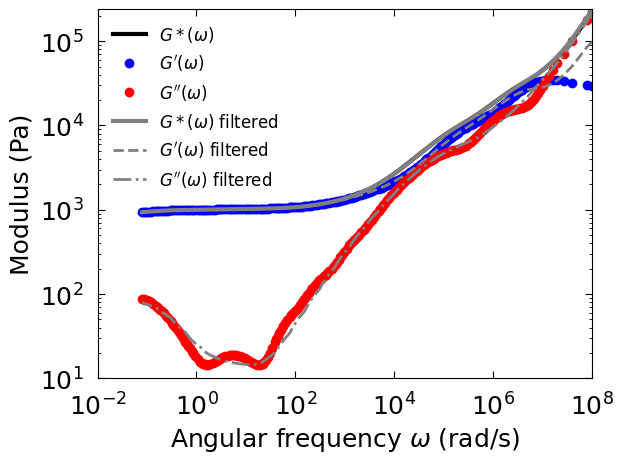

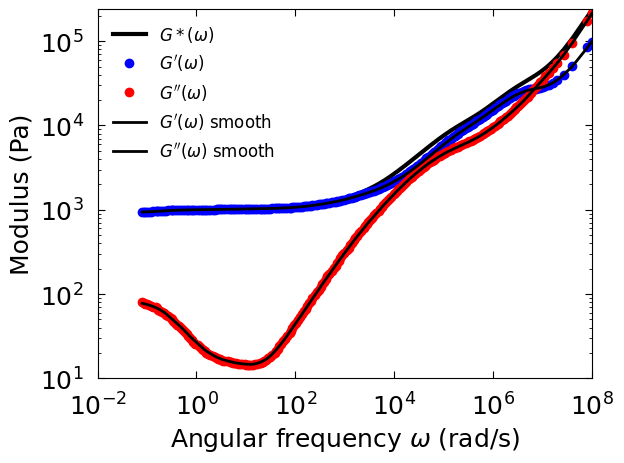

In [8]:
# Parameters
temp = 28+273.15        # temperatur
freq_R = [0.01, 1e8]    # frequency range of the moduli

# If len(gau) == 2, then a low-pass filter is applied to the derivative values. 
# The first value corresponds to the order of the filter, and the second to the critical frequency.
# Else there is no filtering (gau = 0). 
# If filtering is applied, then a smoothing is additionaly applied
gauF = (3,0.03)
#gauF = 0
zfil = microrheology(msdD, temp, freq_R, gauF, radi, mergePath, savePlots=mergePlots)


| Created file                        | Columns                                                                                  |
|------------------------------------|-----------------------------------------------------------------------------------------|
| `zmicrorheology-filtered.txt` or `zmicrorheology.txt` | Ome, zstar, zpr, zppr, zstarFi, zprFi, zpprFi, zprS, zpprS, zC **or** Ome, zstar, zpr, zppr, zC |

| Variable    | Explanation                  |
|------------|------------------------------|
| Ome        | $\omega$  (rad/s)            |
| zstar      | $Z^*$     (Pa)               |
| zpr        | $Z'$      (Pa)               |
| zppr       | $Z''$     (Pa)               |
| zstarFi    | $Z^*$     (Pa)   filtered     |
| zprFi      | $Z'$      (Pa)   filtered           |
| zpprFi     | $Z''$     (Pa)   filtered            |
| zprS       | $Z'$      (Pa)   filtered & smoothed            |
| zpprS      | $Z''$      (Pa)  filtered & smoothed            |
| zC         | $Z^*$      (Pa)  complex            |